In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
%matplotlib inline

In [2]:
MARKERS = ['+', 'x', '.']
COLORS = ['red', 'green', 'blue']

def plot_points(xy, labels):
    
    for i, label in enumerate(set(labels.flatten())):
        points = np.matrix([xy[j,:] for j in range(len(xy)) if labels[j] == label])
        marker = MARKERS[i % len(MARKERS)]
        color = COLORS[i % len(COLORS)]
        plt.scatter(points[:,0], points[:,1], marker=marker, color=color)

def plot_boundary(X, fn):
    
    x_min, x_max = X[:,0].min(), X[:,0].max()
    y_min, y_max = X[:,1].min(), X[:,1].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 100),
        np.linspace(y_min, y_max, 100)
    )

    inputs = np.c_[xx.ravel(), yy.ravel()]
    inputs = np.apply_along_axis(transform_data, 1, inputs)
    
    predictions = fn(inputs)
    predictions = predictions.argmax(axis=1).reshape(xx.shape)

    plt.contour(xx, yy, predictions, colors='black')

In [3]:
def transform_data(x):
    return [x[0], x[1], x[0] ** 2, x[1] ** 2]
    #return x

data = pd.read_csv('data.txt')
XX = data.as_matrix(columns=['alcohol', 'flavanoids'])
#yy = label_binarize(data['class'], [1, 2, 3])[:,0]
#yy = np.array(yy.flatten()).ravel()
yy = np.array([i - 1 for i in data['class']])
print(yy)

training_in = np.array(
    [[0, 0], [1, 1], [2, 0], [-2, 0], [-1, -1], [-1, 1], [-1.5, 1], [3, 3], [3, 0], [-3, 0], [0, -3], [-1, 3], [1, -2],
     [-2, -1.5]])
training_out = np.array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])


training_in = XX
training_out = yy
training_in = np.apply_along_axis(transform_data, 1, training_in)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


weights: [[-1440.1706543   1763.51257324  -323.13070679]
 [  -10.04025173   391.97814941  -381.85653687]
 [  104.92545319  -148.71612549    43.80113983]
 [  600.40991211   376.10354614  -976.85186768]]
bias: [-224.68295288  276.19216919  -51.50957108]
cost: 151.299
predict: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 0 1 1 1 0 1 2 1 2 0 0 0
 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 2 1 1 1 1 1 0 1 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 1 0 1 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
accuracy: 0.88202247191
precision: 0.89132996633
recall: 0.899158841941


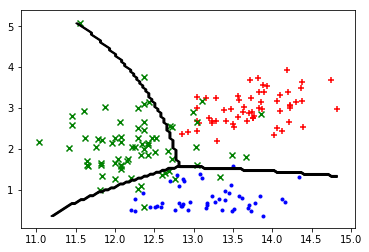

In [4]:
n_features = training_in.shape[1]
n_labels = len(set(training_out))

x = tf.placeholder(tf.float32, [None, n_features], name='X')
y = tf.placeholder(tf.int32, [None], name='y')

W = tf.Variable(tf.zeros([n_features, n_labels]), name='W')
b = tf.Variable(tf.zeros([n_labels]), name='b')

logits = tf.matmul(x, W) + b
guess = tf.nn.softmax(logits)
sm = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
cost = tf.reduce_mean(sm)
opti = tf.train.GradientDescentOptimizer(0.5).minimize(cost)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for i in range(30000):
        sess.run(opti, feed_dict={x: training_in, y: training_out})
        
    print('weights:', sess.run(W))
    print('bias:', sess.run(b))

    p = sess.run(guess, feed_dict={x: training_in}).argmax(axis=1)
    c = sess.run(cost, feed_dict={x: training_in, y: training_out})
    print('cost:', c)
    print('predict:', p)
    print('accuracy:', accuracy_score(training_out, p))
    print('precision:', precision_score(training_out, p, average='macro'))
    print('recall:', recall_score(training_out, p, average='macro'))
    
    def predict(inputs):
        return sess.run(guess, feed_dict={x: inputs})
    
    plt.show()
    plot_boundary(training_in, predict)
    plot_points(training_in, training_out)